<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Se corre una vez al abrir una nueva sesión
# !pip install yfinance
# !pip install fitter
# !pip install pingouin
# !pip install hurst

In [63]:
import numpy as np
import random as rnd

import pandas as pd
import pingouin as pg
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fitter import Fitter, get_common_distributions, get_distributions
import pylab 
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson, kstest, chisquare
import warnings
warnings.filterwarnings("ignore")
from hurst import compute_Hc
from IPython.display import display, Math

import matplotlib.pyplot as plt # gráficas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt

import seaborn as sns #gráficas
plt.style.use('ggplot') # estilo de gráficas

# Pronóstico 2: EDE Lineal en Sentido Estricto con Nivel de Tendencia Constante

\begin{equation}
  dX_t = \big(F(t)X_t + f(t)\big)dt + g(t)dB_t, \quad X_{t_0} = X_0
\end{equation}

definida sobre $[t_0, T]$, donde ${F,f, g}$ son funciones deterministas continuas de valores en $\mathbb{R}$ y $\{B_t\}_{t \geq 0}$ es un MBEU. Su solución para $t_0=0$ es

\begin{equation}
  X_t = X_0\exp\Bigg[\int_0^tF(s) ds\Bigg] + \exp\Bigg[\int_0^tF(s) ds\Bigg]\Bigg\{\int_0^t\Bigg[-\int_0^s F(u) du\Bigg]f(s)ds + \int_0^t\exp\Bigg[-\int_0^sF(u)du\Bigg]g(s)dB_s\Bigg\}
\end{equation}


## 2. Simulación (Proceso de reversión a la media Ornstein-Uhlenbeck)


De acuerdo con [Marín, Palacio (2013)](https://downloads.hindawi.com/journals/jps/2013/239384.pdf) este proceso, también conocido como proceso de reversión a la media de un factor con parámetros constantes, puede escribirse como

\begin{equation}
  dX_t = \alpha(\mu - X_t)dt + \sigma X_t^\gamma dB_t, \quad X_0=x
\end{equation}

con $t \in [0,T]$, $\alpha>0$, $\sigma>0$, $\mu \in \mathbb{R}$, $\gamma \in [0, 1.5]$ y $\{B_t\}_{t \geq 0}$ es un MBEU definido en un espacio de probabilidad completo $(\Omega, \mathcal{F}, \mathbb{P})$. Donde a cada parámetro se le llama

*   $\alpha$: tasa de reversión,
*   $\mu$: nivel de reversión a la media o tendencia de equilibrio a largo plazo,
*   $\sigma$: parámetro asociado a la volatilidad,
*   $\gamma$: parámetro que determina la sensibilidad de la varianza al nivel de $X_t$.

Si se asume que $\gamma = 0$, entonces la ecuación se reduce a

\begin{equation}
  dX_t = \alpha(\mu - X_t)dt + \sigma dB_t, \quad X_0=x
\end{equation}

Note que esta es una EDE Lineal en Sentido Estricto con Nivel de Tendencia Constante donde $F(t)=-\alpha$, $f(t)=\alpha\mu$, $g(t)=\sigma$, la cual tiene solución

\begin{align*}
  X_t &= \mu + (X_0 - \mu)\exp[-\alpha t] + \sigma \exp[-\alpha t] \int_0^t \exp[\alpha s] dB_s\\
\end{align*}

Aproximando con Euler-Maruyama

\begin{align*}
  X(t) &= \mu + (X(t-1) - \mu)\exp[-\alpha \Delta t] + \sigma \exp[-\alpha \Delta t] \Delta B_t
\end{align*}

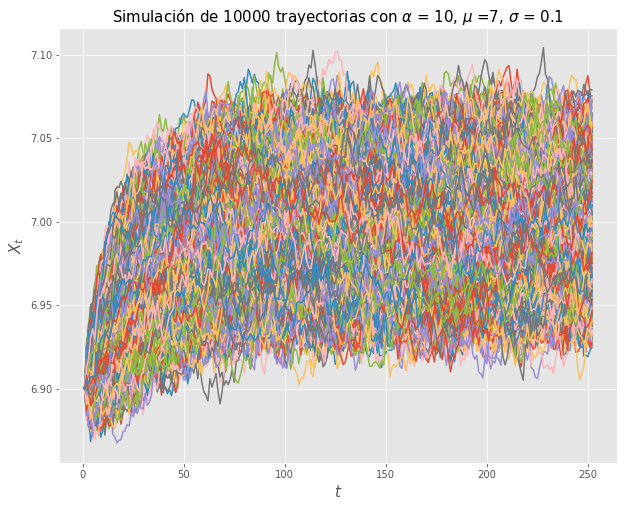

In [64]:
# EDE Lineal en Sentido Estricto con Nivel de Tendencia Constante
# Proceso de reversión a la media de Ornstein-Uhlenbeck

l = 10000 # número de simulaciones
p = 252 # número de observaciones

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]
alpha = 10
mu = 7
sigma = 0.1
X0 = mu-0.1 # Valor inicial

plt.figure(figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X[sim, t] = mu + (X[sim, t-1] - mu)*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt
  plt.plot(p*T, X[sim]);

title = 'Simulación de ' + str(l) + r' trayectorias con $\alpha$ = ' + str(alpha) + ', $\mu$ =' + str(mu) + ', $\sigma$ = ' + str(sigma)
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

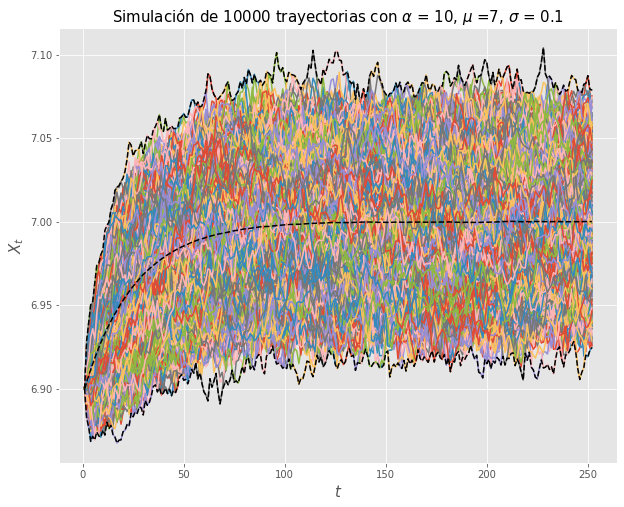

In [65]:
# Análisis longitudinal
X_max = np.amax(X, axis=0) # Trayectoria máxima
X_min = np.amin(X, axis=0) # Trayectoria mínima
X_mean = np.mean(X, axis=0) # Trayectoria promedio

plt.figure(figsize=(10,8))
[plt.plot(p*T, X[_]) for _ in range(l)];

plt.plot(p*T, X_max, '--', color='black');
plt.plot(p*T, X_min, '--', color='black');
plt.plot(p*T, X_mean, '--', color='black');

title = 'Simulación de ' + str(l) + r' trayectorias con $\alpha$ = ' + str(alpha) + ', $\mu$ =' + str(mu) + ', $\sigma$ = ' + str(sigma)
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

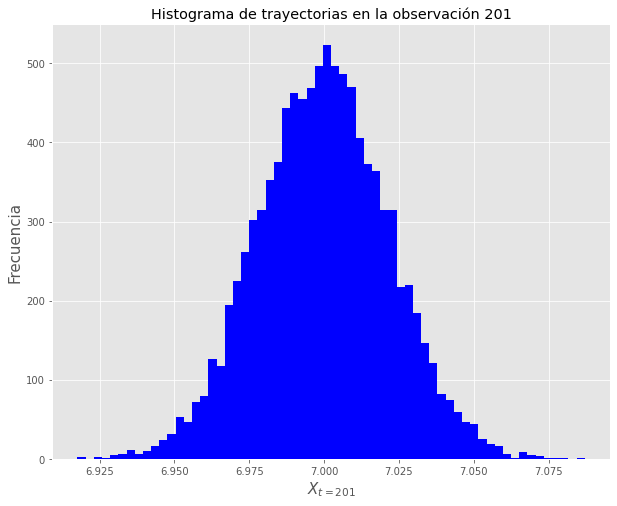

In [66]:
# Análisis transversal
X_tra = X[:, 200]

plt.figure(figsize=(10,8))
_ = plt.hist(X_tra, bins='auto', color='blue')
plt.title('Histograma de trayectorias en la observación 201');
plt.xlabel('$X_{t=201}$', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

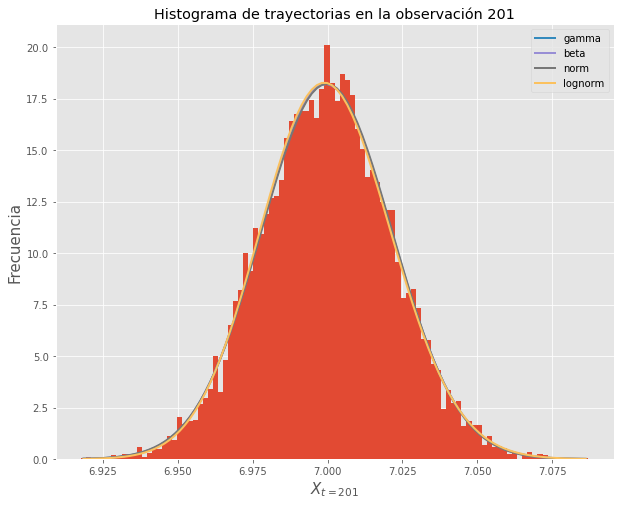

In [67]:
# Ajuste a varias distribuciones
plt.figure(figsize=(10,8))
f = Fitter(X_tra, distributions=['lognorm', 'gamma', 'beta', 'norm'])
f.fit()
f.summary()

plt.title('Histograma de trayectorias en la observación 201');
plt.xlabel('$X_{t=201}$', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

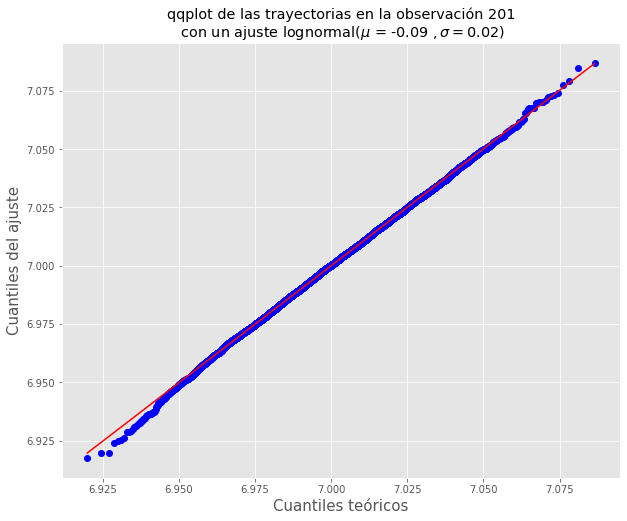

In [68]:
# QQplot respecto a una lognormal
params = f.fitted_param["lognorm"]
sigma_hat = str(round(params[0], 2))
mu_hat = str(round(np.log(params[2]), 2))

plt.figure(figsize=(10,8))
stats.probplot(X_tra, dist=stats.lognorm, sparams=params, plot=pylab);

title = 'qqplot de las trayectorias en la observación 201\n con un ajuste \
lognormal($\mu$ = ' + mu_hat + ' $,\sigma = $' + sigma_hat + ')'
plt.title(title);
plt.xlabel('Cuantiles teóricos', fontsize = 15);
plt.ylabel('Cuantiles del ajuste', fontsize = 15);

In [69]:
# Autocorrelación parcial PACF
import pandas as pd
from statsmodels.tsa.stattools import pacf
df = pd.DataFrame(X)
df_pacf = pd.DataFrame([pacf(df.iloc[i,:].to_numpy()) for i in range(l)])

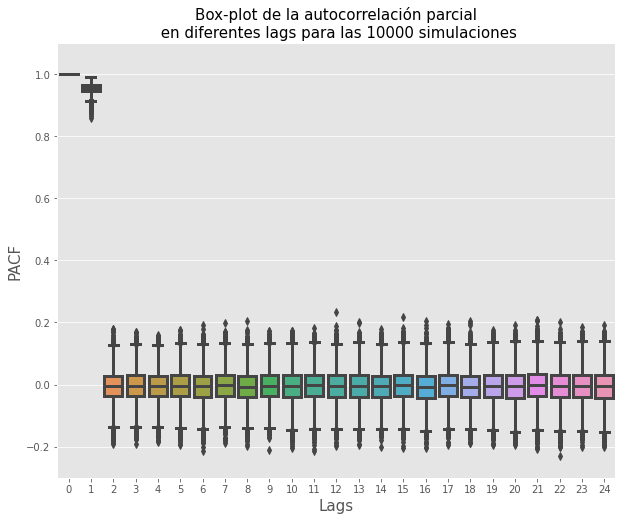

In [70]:
# Visualizar

plt.figure(figsize = (10, 8));
sns.boxplot(data = df_pacf, linewidth = 3);
plt.xlabel('Lags', fontsize = 15);
plt.ylabel('PACF', fontsize = 15);

title = 'Box-plot de la autocorrelación parcial\n en diferentes lags para las '\
         + str(l) + ' simulaciones'
plt.title(title, fontsize = 15);
plt.ylim([-0.3, 1.1]);

In [71]:
# Condiciones a nivel de distribución

def test_normalidad(data):

  if data.shape[1] > 1: # Multivariado
    norm = data.agg(normaltest).iloc[1,:] # H0: normal
    shap = data.agg(shapiro).iloc[1,:] # H0: normal, Skweness & Kurtosis
    ande = data.agg(anderson) # H0: normal
    ande_cv = ande.iloc[1][0][2]
    ande = ande.iloc[0]

    norm = norm[norm > 0.05].count()
    shap = shap[shap > 0.05].count()
    ande = ande[ande < ande_cv].count()
    resul_uni = 100*np.array([norm/l, shap/l, ande/l])

  else: # Univariado
    
    norm = data.agg(normaltest)
    shap = data.agg(shapiro)
    ande = data.agg(anderson)
    ande_cv = ande.iloc[1][0][2]
    ande = ande.iloc[0]

    norm = list(norm.iloc[1] > 0.5)[0]
    shap = list(shap.iloc[1] > 0.5)[0]
    ande = list(ande < ande_cv)[0]
    resul_uni = [norm, shap, ande]
  
  tests_uni = ['K^2', 'Shapiro', 'Anderson-Darling']

  if data.shape[1] > 1: # Multivariado

    count1 = 0
    for i in range(200):
      r = pg.multivariate_normality(data.iloc[:,0+50*i:50*(i+1)], alpha=.05)
      if r.normal:
        count1 += r.normal

    count2 = 0
    for i in range(2000):
      r = pg.multivariate_normality(data.iloc[:,0+5*i:5*(i+1)], alpha=.05)
      if r.normal:
        count2 += r.normal
    
    resul = np.append(resul_uni, 100*np.array([count1/200, count2/2000]))
    tests = tests_uni + ['HZ(200*50)', 'HZ(2000*5)']
    text = 'Éxito (%)'
  
  else: # Univariado
    resul = resul_uni 
    tests = tests_uni
    text = 'Éxito'

  r = pd.DataFrame({'Test':tests, text:resul})
  return r

In [72]:
df = pd.DataFrame(X) # Datos como dataframe
rendimientos =  np.log(df.T).diff().dropna()
r = test_normalidad(rendimientos)
r

,Test,Éxito (%)
0,K^2,94.92
1,Shapiro,94.94
2,Anderson-Darling,95.61
3,HZ(200*50),99.50
4,HZ(2000*5),94.50


In [73]:
H_mean = 0
H_min = 0
H_max = 0

H_mean, _, _ = compute_Hc(X_mean)
H_min, _, _ = compute_Hc(X_min)
H_max, _, _ = compute_Hc(X_max)

print('H_mean = ' + str(round(H_mean, 2)))
print('H_min = ' + str(round(H_min, 2)))
print('H_max = ' + str(round(H_max, 2)))

H_mean = 0.5
H_min = 0.47
H_max = 0.79


## Esperanza y Varianza a largo plazo

La esperanza y varianza teóricas son

\begin{equation}
  \mathbb{E}[X_t] = \mu + (X_0 - \mu) \exp [-\alpha t]
\end{equation}


\begin{equation}
  \mathbb{V}[X_t] = \frac{\sigma^2}{2\alpha} (1-\exp[-2\alpha t])
\end{equation}

donde en este caso $X_0 = 1$

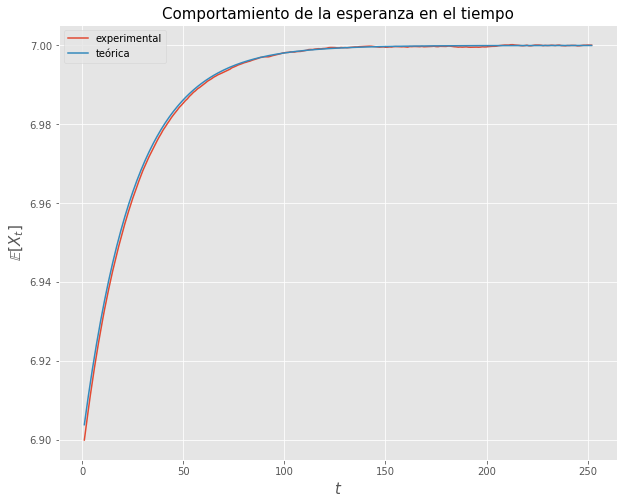

In [74]:
# Esperanza y Varianza de largo plazo

plt.figure(figsize=(10,8))
plt.plot(p*T, X_mean)
plt.plot(p*T, mu + (X0 - mu)*np.exp(-alpha*T))
plt.legend(['experimental', 'teórica']);

plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$\mathbb{E}[X_t]$', fontsize = 15);
plt.title('Comportamiento de la esperanza en el tiempo', fontsize = 15);

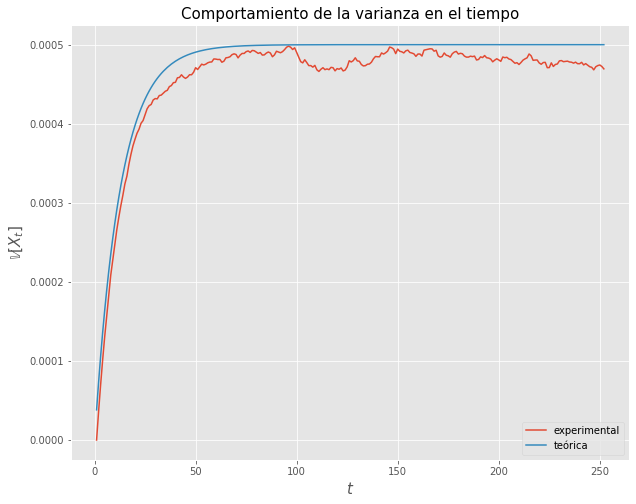

In [75]:
X_var = np.var(X, axis=0)

plt.figure(figsize=(10,8))
plt.plot(p*T, X_var)
plt.plot(p*T, (sigma**2/(2*alpha))*(1 - np.exp(-2*alpha*T)))
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$\mathbb{V}[X_t]$', fontsize = 15);
plt.title('Comportamiento de la varianza en el tiempo', fontsize = 15);
plt.legend(['experimental', 'teórica']);

## 3. Selección de una acción financiera caracterizada por la EDE

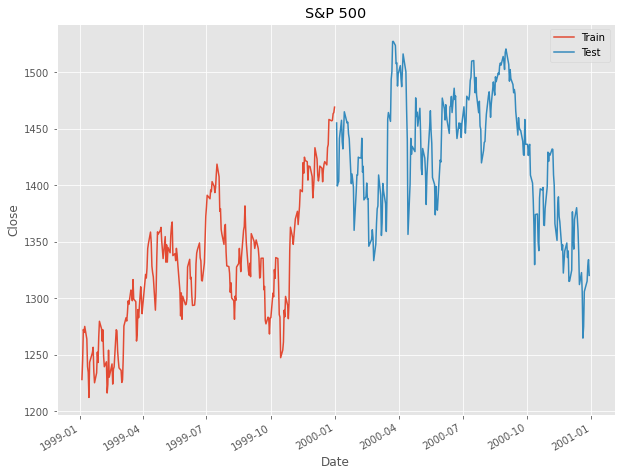

In [76]:
# yfinance package de https://pypi.org/project/yfinance/

import yfinance as yf
stock = "^GSPC"
name = "S&P 500"

start = 1999
end = start + 1

# start = 2017
# end = start + 1

train = yf.download(stock, start=str(start)+"-01-01", end=str(end)+"-01-02", progress=False)
train = train["Close"]

test = yf.download(stock, start=str(end)+"-01-02", end=str(end+1)+"-01-02", progress=False)
test = test["Close"]

plt.figure(figsize=(10,8))
train.plot(title=name);
test.plot(title=name);
plt.ylabel('Close');
plt.legend(['Train', 'Test']);

,Test,Éxito
0,K^2,True
1,Shapiro,True
2,Anderson-Darling,True


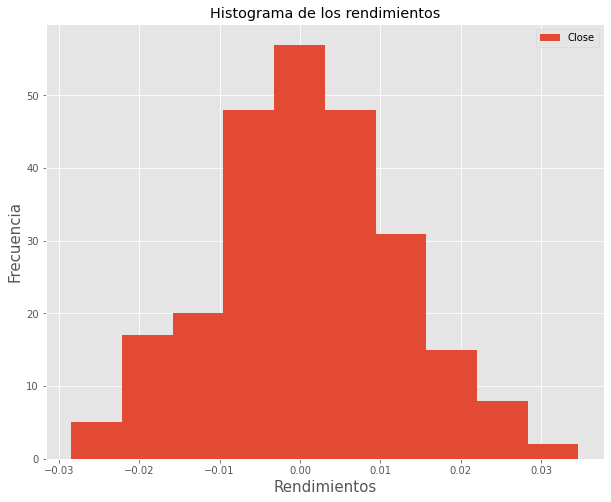

In [77]:
# Condiciones a nivel de distribución (test de normalidad)
data = pd.DataFrame(train)
rendimientos = np.log(data).diff().dropna()

_ = rendimientos.plot.hist(figsize=(10,8));
plt.title('Histograma de los rendimientos');
plt.xlabel('Rendimientos', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);
display(test_normalidad(rendimientos))

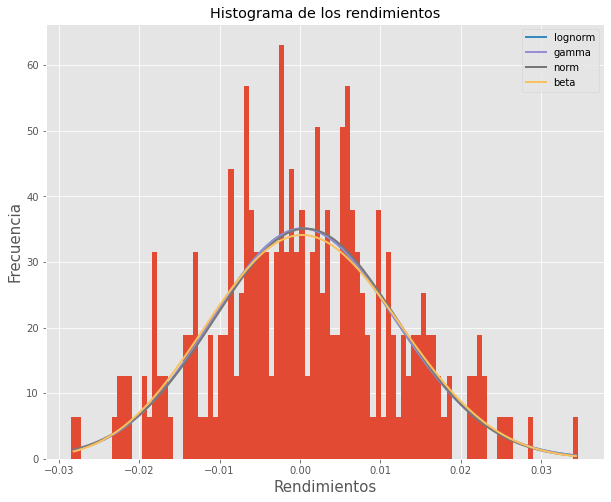

In [78]:
# Ajuste normal
plt.figure(figsize=(10,8))
f = Fitter(rendimientos, distributions=['lognorm', 'gamma', 'beta', 'norm'])
f.fit()
f.summary()
plt.title('Histograma de los rendimientos');
plt.xlabel('Rendimientos', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

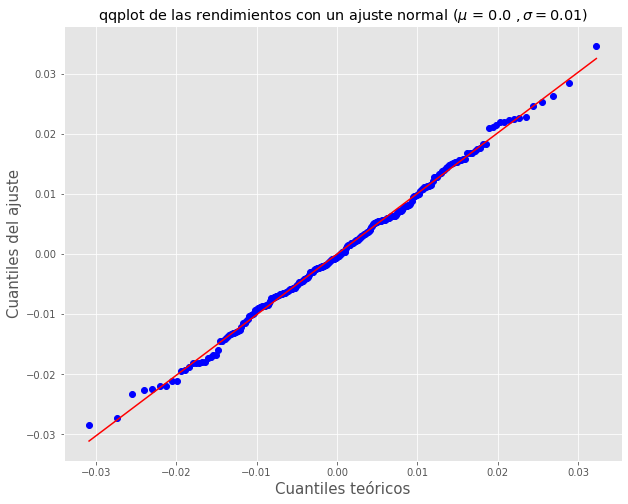

In [79]:
# QQplot respecto al ajuste normal
params = f.fitted_param["norm"]
mu_hat = round(params[0], 2)
sigma_hat = round(params[1],2)

plt.figure(figsize=(10,8))
stats.probplot(rendimientos.iloc[:,0].to_numpy(), dist=stats.norm, sparams=params, plot=pylab);

title = 'qqplot de las rendimientos con un ajuste normal ($\mu$ = ' + str(mu_hat) + ' $,\sigma = $' + str(sigma_hat) + ')'
plt.title(title);
plt.xlabel('Cuantiles teóricos', fontsize = 15);
plt.ylabel('Cuantiles del ajuste', fontsize = 15);

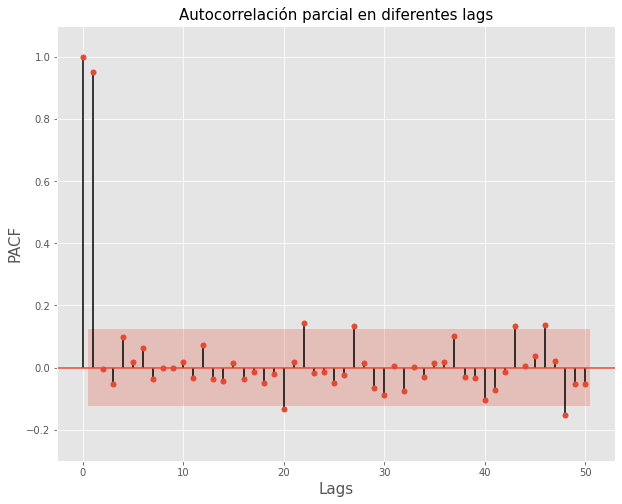

In [80]:
# Autocorrelación parcial de orden 1
fig, ax = plt.subplots(figsize=(10,8))
plot_pacf(data, ax=ax, lags=50);
plt.xlabel('Lags', fontsize = 15);
plt.ylabel('PACF', fontsize = 15);
plt.title('Autocorrelación parcial en diferentes lags', fontsize = 15);
plt.ylim([-0.3, 1.1]);

In [81]:
# Dimensión fractal (exponente de Hurst)
H, _, _ = compute_Hc(data)
D = 2-H
print('Exponente de Hurst: H = ' + str(round(H,2)))
print('Dimensión fractal:  D = ' + str(round(D,2)))

Exponente de Hurst: H = 0.41
Dimensión fractal:  D = 1.59


## 4. Estimación de parámetros

Para estimar los parámetros $\theta = [\alpha, \mu, \sigma]$ se tienen los  [estimadores](https://downloads.hindawi.com/journals/jps/2013/239384.pdf) (con $\gamma = 0$)

\begin{equation}
\hat{\alpha} = \frac{ED-B^2-AD+BC}{(ED-B^2) \Delta t}, \quad \hat{\mu} = \frac{A-E(1-\hat{\alpha} \Delta t)}{\hat{\alpha} B \Delta t}, \quad \hat{\sigma} = \sqrt{\frac{1}{T \Delta t} \sum_{i=1}^T \bigg(X(i)-X(i-1)-\hat{\alpha}\big(\hat{\mu}-X(i-1)\big)\Delta t\bigg)^2}
\end{equation}

donde $A$, $B$, $C$, $D$ y $E$ son

\begin{equation}
A = \sum_{i=1}^T X(i)X(i-1), \quad B = \sum_{i=1}^T X(i-1), \quad C = \sum_{i=1}^T X(i), \quad D = T, \quad E = \sum_{i=1}^T \big(X(i-1)\big)^2
\end{equation}

In [82]:
T = p

A = (data*data.iloc[1:]).sum()[0]
B = data.iloc[1:].sum()[0]
C = data.sum()[0]
D = T
E = (data.iloc[1:]**2).sum()[0]

alpha_hat = (E*D-B**2-A*D+B*C)/((E*D-B**2)*dt)
mu_hat = (A-E*(1-alpha_hat*dt))/(alpha_hat*B*dt)
sigma_sum = ((data-data.iloc[1:]-alpha_hat*(mu_hat-data.iloc[1:])*dt)**2).sum()[0]
sigma_hat = np.sqrt(1/(T*dt)*sigma_sum)

display(Math(r'\hat{\alpha} = ' + str(round(alpha_hat, 2))))
display(Math(r'\hat{\mu} = ' + str(round(mu_hat, 2))))
display(Math(r'\hat{\sigma} = ' + str(round(sigma_hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Entonces su solución estimada es de la forma

\begin{equation}
  \hat{X}(t) = \hat{\mu} + (X(t-1) - \hat{\mu})\exp[-\hat{\alpha} \Delta t] + \hat{\sigma} \Delta B_t, \quad \hat{X}(0) = X(0)
\end{equation}

In [83]:
# Escenario optimista
# EDEL en Sentido Estricto con Nivel de Tendencia Constante

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat1 = np.zeros((l,p))
X_hat1 = pd.DataFrame(X_hat1)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

alpha = alpha_hat
mu = mu_hat*1.075
sigma = sigma_hat

X0 = mu - 0.01 # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat1.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat1.iloc[sim, t] = mu + (X_hat1.iloc[sim, t-1] - mu)*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

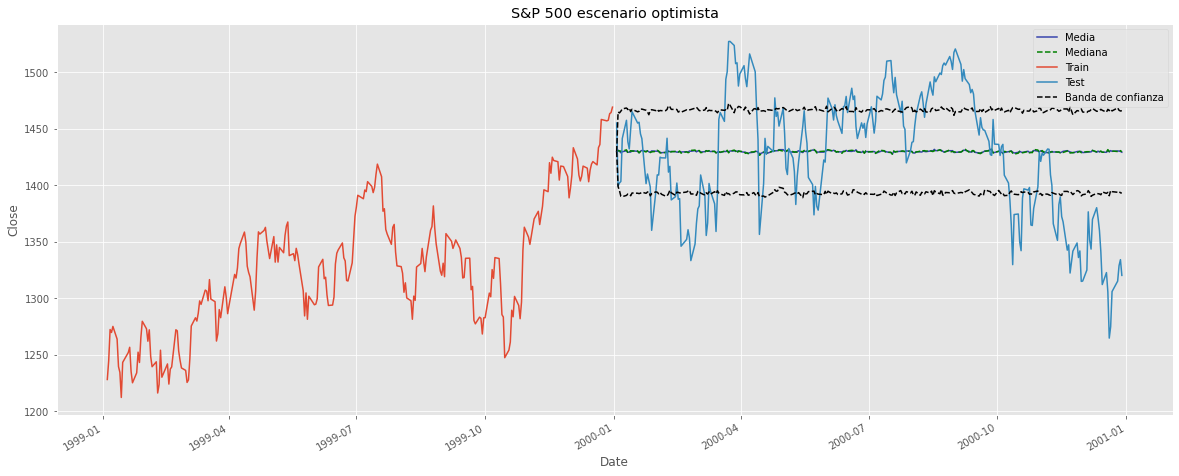

In [84]:
# Visualizar

fig1 = plt.figure(figsize=(20,8))

X_hat_mean1 = pd.Series(X_hat1.mean(axis=0).values, index=test.index)
X_hat_mean1.plot(color='#3743ad');
X_hat_median1 = pd.Series(X_hat1.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median1.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario optimista');

# Bandas de confianza
X_hat_hi1 = pd.Series(X_hat1.quantile(q=0.95, axis=0).values, index=test.index)
X_hat_hi1.plot(style='--', color='black');
X_hat_lo1 = pd.Series(X_hat1.quantile(q=0.05, axis=0).values, index=test.index)
X_hat_lo1.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [85]:
# Eficiencia de las bandas
band_ef1 = (X_hat_lo1 <= test) & (test <= X_hat_hi1)
band_ef1 = (band_ef1.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef1, 2)) + ' %')

Efectividad de bandas = 45.24 %


In [86]:
# Escenario neutral
# EDEL en Sentido Estricto con Nivel de Tendencia Constante

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat2 = np.zeros((l,p))
X_hat2 = pd.DataFrame(X_hat1)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

alpha = alpha_hat
mu = mu_hat
sigma = sigma_hat

X0 = mu - 0.1 # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat2.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat2.iloc[sim, t] = mu + (X_hat2.iloc[sim, t-1] - mu)*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

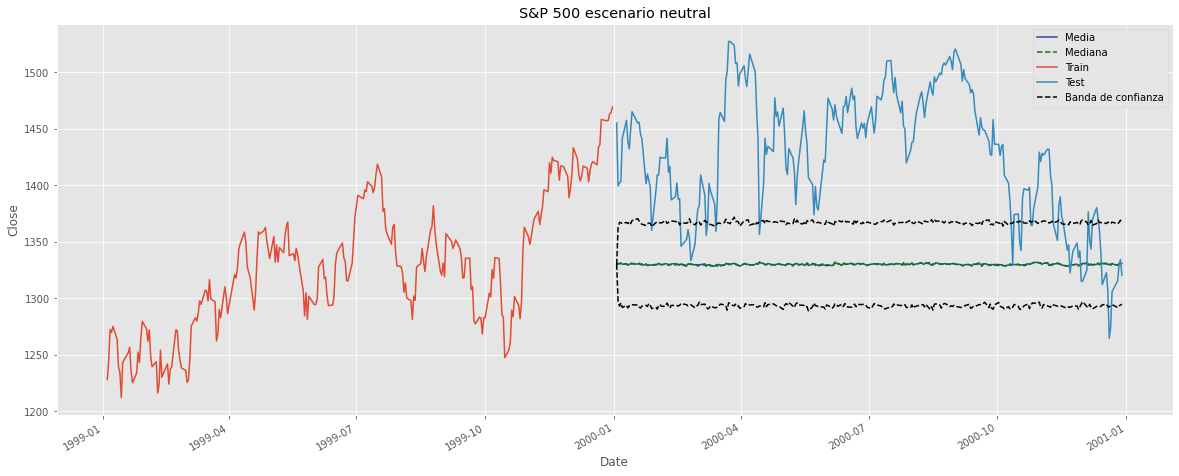

In [87]:
# Visualizar

fig2 = plt.figure(figsize=(20,8))

X_hat_mean2 = pd.Series(X_hat2.mean(axis=0).values, index=test.index)
X_hat_mean2.plot(color='#3743ad');
X_hat_median2 = pd.Series(X_hat2.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median2.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario neutral');

# Bandas de confianza
X_hat_hi2 = pd.Series(X_hat2.quantile(q=0.95, axis=0).values, index=test.index)
X_hat_hi2.plot(style='--', color='black');
X_hat_lo2 = pd.Series(X_hat2.quantile(q=0.05, axis=0).values, index=test.index)
X_hat_lo2.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [88]:
# Eficiencia de las bandas
band_ef2 = (X_hat_lo2 <= test) & (test <= X_hat_hi2)
band_ef2 = (band_ef1.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef2, 2)) + ' %')

Efectividad de bandas = 17.95 %


In [89]:
# Escenario pesimista
# EDEL en Sentido Estricto con Nivel de Tendencia Constante

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat3 = np.zeros((l,p))
X_hat3 = pd.DataFrame(X_hat1)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

alpha = alpha_hat
mu = mu_hat*0.925
sigma = sigma_hat
X0 = mu - 0.1 # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat3.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat3.iloc[sim, t] = mu + (X_hat3.iloc[sim, t-1] - mu)*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

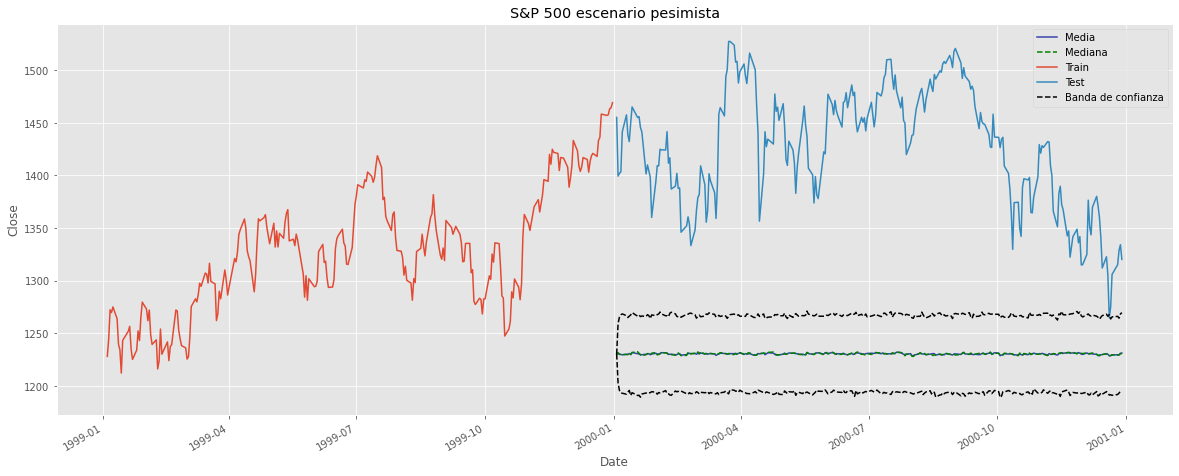

In [90]:
# Visualizar

fig3 = plt.figure(figsize=(20,8))

X_hat_mean3 = pd.Series(X_hat3.mean(axis=0).values, index=test.index)
X_hat_mean3.plot(color='#3743ad');
X_hat_median3 = pd.Series(X_hat3.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median3.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario pesimista');

# Bandas de confianza
X_hat_hi3 = pd.Series(X_hat3.quantile(q=0.95, axis=0).values, index=test.index)
X_hat_hi3.plot(style='--', color='black');
X_hat_lo3 = pd.Series(X_hat3.quantile(q=0.05, axis=0).values, index=test.index)
X_hat_lo3.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [91]:
band_ef3 = (X_hat_lo3 <= test) & (test <= X_hat_hi3)
band_ef3 = (band_ef3.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef3, 2)) + ' %')

Efectividad de bandas = 0.4 %
